# Model explanability w/ Grad-CAM in PyTorch
[Blog post (jss367 2023)](https://jss367.github.io/model-explainability-with-grad-cam-in-pytorch.html)

Applies GradCAM to a default ResNet18 model, targeting the last convolutional layer.

Direct copy of steps in blog post above by [Julius Simonelli](https://github.com/jss367), using our own data.




In [1]:
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from pyxtend import struct
from torchvision.models.resnet import ResNet18_Weights

In [6]:
image_path = "../data/example/mba/frame_013.jpg"
input_image = Image.open(image_path)

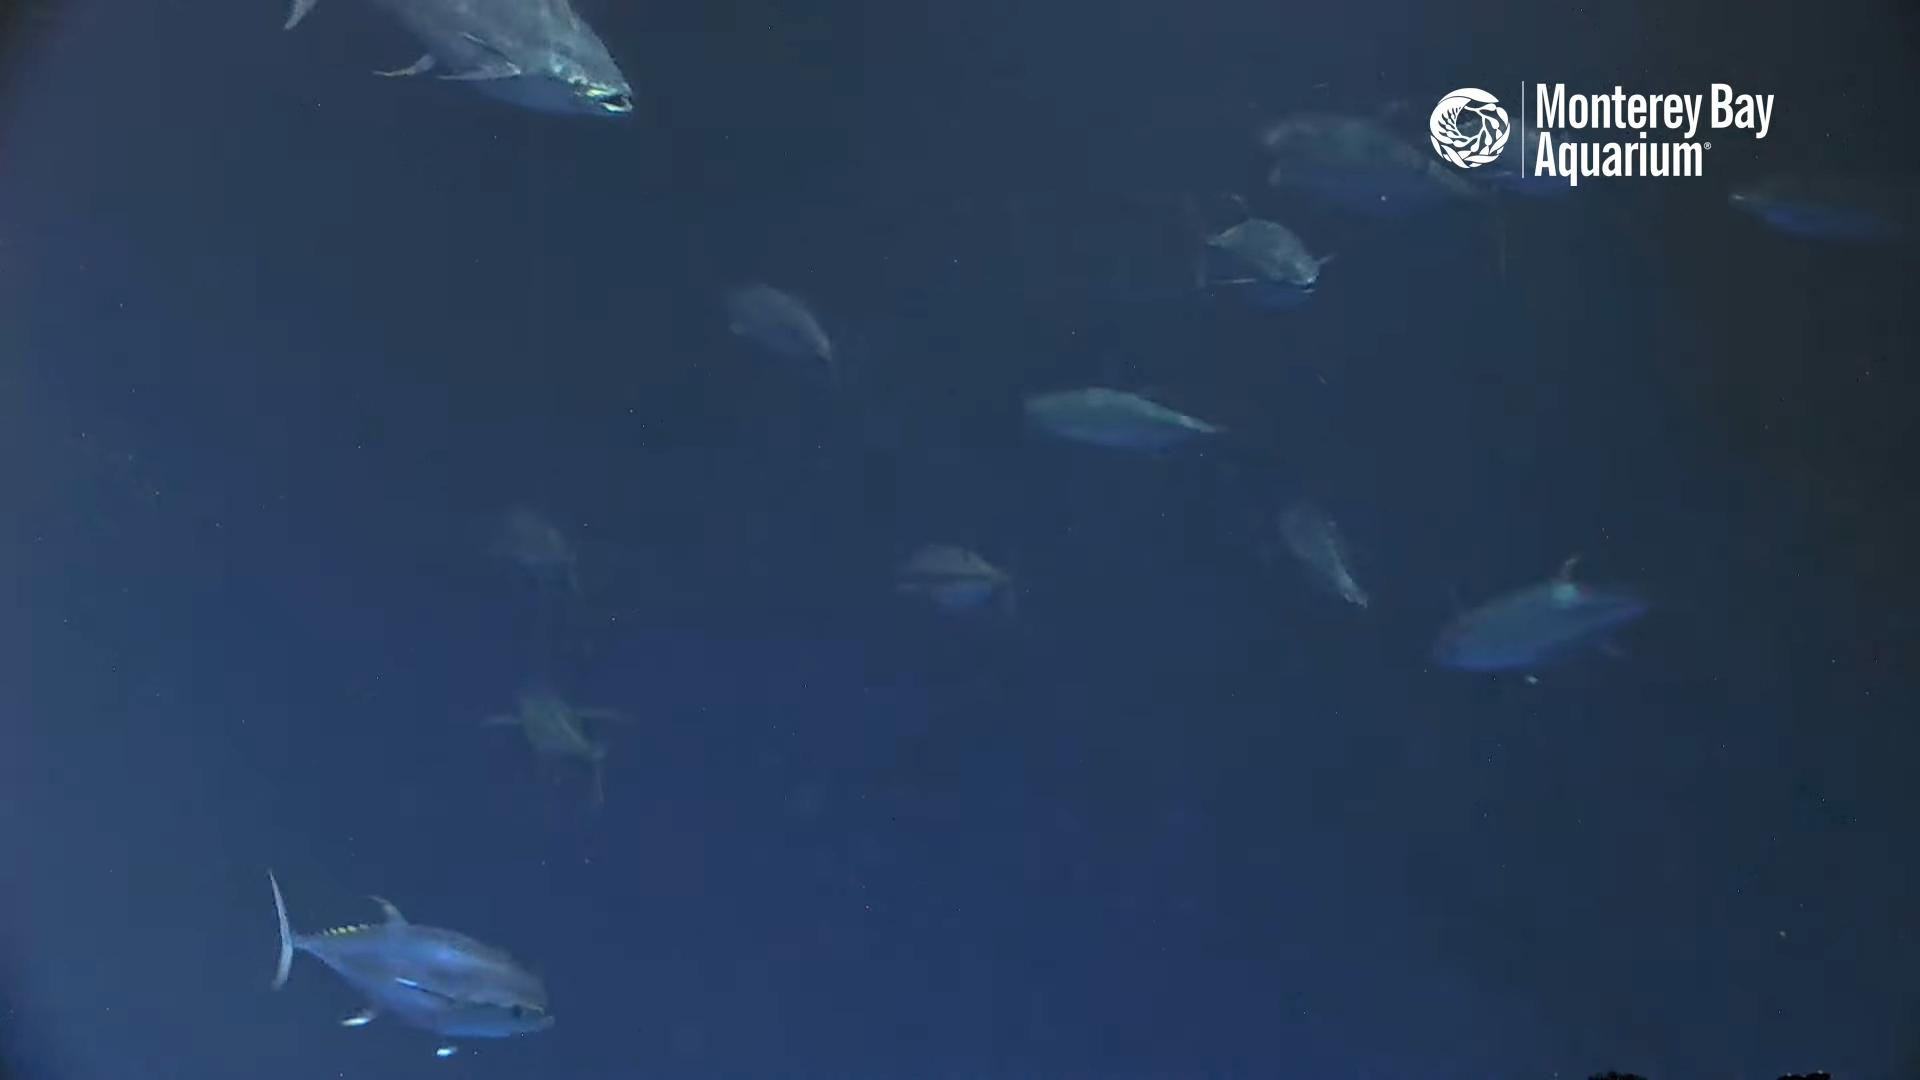

In [7]:
input_image

In [8]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
IMAGENET_MEAN_VALUES = [0.485, 0.456, 0.406]
IMAGENET_STD_VALUES = [0.229, 0.224, 0.225]

preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN_VALUES, std=IMAGENET_STD_VALUES),
    ]
)


In [10]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [11]:
logits = model(input_batch)

In [12]:
struct(logits)

{'Tensor': ['torch.float32, shape=(1, 1000)']}

In [13]:
probs = torch.softmax(logits, dim=1)
pred_class_idx = torch.argmax(probs, dim=1).item()
predicted_prob = probs[0, pred_class_idx].item()

In [14]:
IMAGENET_CLASSES_URL = "https://raw.githubusercontent.com/jss367/files/main/imagenet_classes.json"
class_labels = json.loads(requests.get(IMAGENET_CLASSES_URL).text)
struct(class_labels, examples=True)


{'list': ['tench', 'goldfish', 'great white shark', '...1000 total']}

In [15]:
predicted_class_name = class_labels[pred_class_idx]
print(f"Predicted class: {predicted_class_name} (index: {pred_class_idx}, probability: {predicted_prob:.2%})")

Predicted class: hammerhead shark (index: 4, probability: 29.47%)


In [16]:
def find_last_conv_layer(model: nn.Module) -> tuple:
    last_conv_layer_name = None
    last_conv_layer = None

    for layer_name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            last_conv_layer_name = layer_name
            last_conv_layer = layer

    return last_conv_layer_name, last_conv_layer

In [17]:
layer_name, target_layer = find_last_conv_layer(model)
print(layer_name)

layer4.1.conv2


In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.full_backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def full_backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def compute_heatmap(self, input_batch, class_idx=None):
        # Forward pass
        logits = self.model(input_batch)
        self.model.zero_grad()

        if class_idx is None:
            class_idx = torch.argmax(logits, dim=1).item()

        # Compute gradients for the target class
        one_hot_output = torch.zeros_like(logits)
        one_hot_output[0, class_idx] = 1
        logits.backward(gradient=one_hot_output)

        # Compute Grad-CAM heatmap
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1, keepdim=True)
        heatmap = torch.relu(heatmap)  # ReLU removes negative values
        heatmap /= torch.max(heatmap)  # Normalize to [0, 1]

        # Get the predicted class probability
        probs = torch.softmax(logits, dim=1)
        predicted_prob = probs[0, class_idx].item()

        return heatmap.squeeze().cpu().numpy(), class_idx, predicted_prob

In [19]:
target_layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [20]:
gradcam = GradCAM(model, target_layer)

heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(input_batch)

In [21]:
predicted_class_name = class_labels[predicted_class_idx]
print(f"Predicted class: {predicted_class_name} (index: {predicted_class_idx}, probability: {predicted_prob:.2%})")

Predicted class: hammerhead shark (index: 4, probability: 29.47%)


img (1080, 1920, 3)
heatmap (1080, 1920)


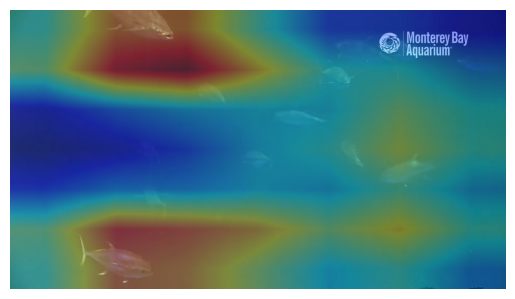

In [22]:
def visualize_heatmap(img_path: str, heatmap: np.ndarray) -> None:
    # Read the image from the given file path
    img = cv2.imread(img_path)
    print("img", img.shape)
    
    # Resize the heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    print("heatmap", heatmap.shape)

    # Normalize the heatmap values to the range [0, 255] and cast to uint8
    heatmap = np.uint8(255 * heatmap)
    
    # Apply the JET colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Blend the original image with the heatmap (60% original, 40% heatmap)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the blended image in RGB format
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

visualize_heatmap(image_path, heatmap)

In [23]:
heatmap.shape

(7, 7)

In [24]:
class_labels

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [26]:
interesting_class_names = [
    "eel",
    "great white shark",
    "stingray",
    "garfish",
    "shipwreck",
    "grey whale",
    "plastic bag",
    "coral reef",
    "bubble"
]


interesting_classes = {
    class_name: class_labels.index(class_name)
    for class_name in interesting_class_names
}

interesting_classes

{'eel': 390,
 'great white shark': 2,
 'stingray': 6,
 'garfish': 395,
 'shipwreck': 913,
 'grey whale': 147,
 'plastic bag': 728,
 'coral reef': 973,
 'bubble': 971}

img (1080, 1920, 3)
heatmap (1080, 1920)


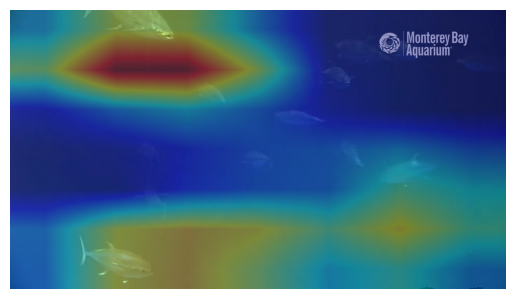

Predicted class: eel (index: 390, probability: 0.05%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


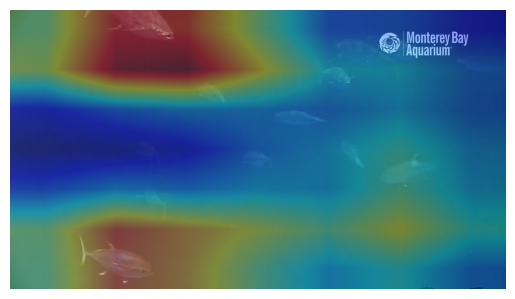

Predicted class: great white shark (index: 2, probability: 15.09%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


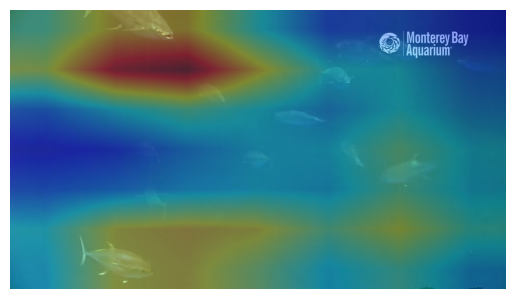

Predicted class: stingray (index: 6, probability: 0.64%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


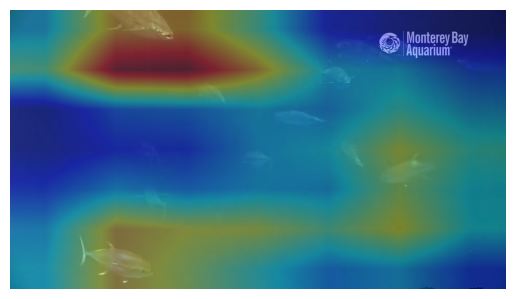

Predicted class: garfish (index: 395, probability: 0.40%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


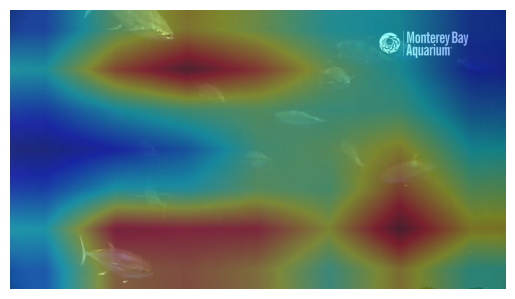

Predicted class: shipwreck (index: 913, probability: 0.23%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


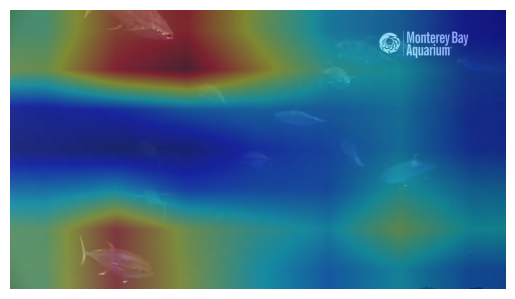

Predicted class: grey whale (index: 147, probability: 0.34%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


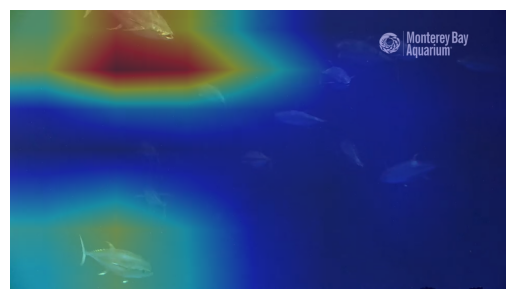

Predicted class: plastic bag (index: 728, probability: 0.13%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


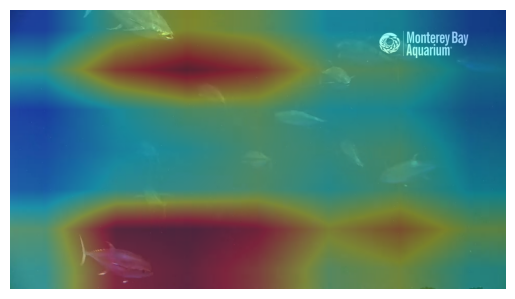

Predicted class: coral reef (index: 973, probability: 0.39%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1080, 1920, 3)
heatmap (1080, 1920)


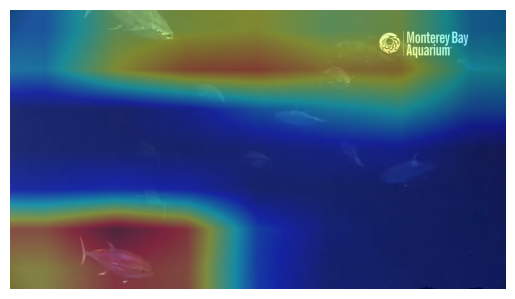

Predicted class: bubble (index: 971, probability: 1.30%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [30]:
for class_name, class_idx in interesting_classes.items():
    heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(input_batch, class_idx)
    predicted_class_name = class_labels[predicted_class_idx]
    visualize_heatmap(image_path, heatmap)
    print(f"Predicted class: {class_name} (index: {class_idx}, probability: {predicted_prob:.2%})")
    print("~~"*40)

# Pipeline

img (1194, 2152, 3)
heatmap (1194, 2152)


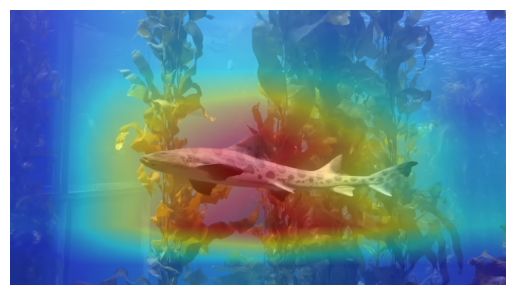

Predicted class: hammerhead shark (index: 4, probability: 77.77%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


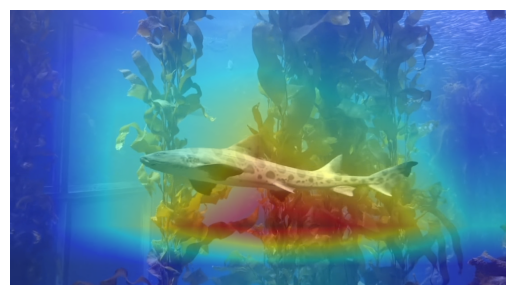

Predicted class: eel (index: 390, probability: 0.11%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


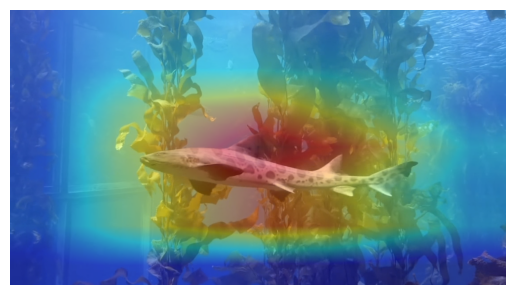

Predicted class: great white shark (index: 2, probability: 1.01%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


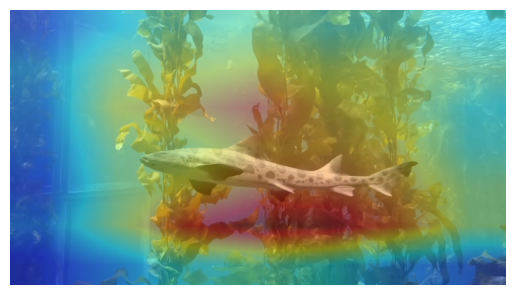

Predicted class: stingray (index: 6, probability: 0.05%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


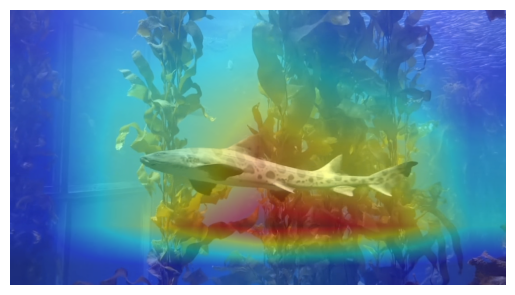

Predicted class: garfish (index: 395, probability: 0.42%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


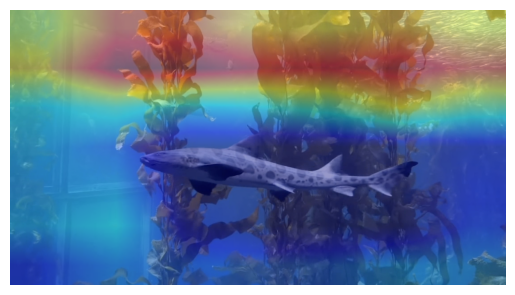

Predicted class: shipwreck (index: 913, probability: 0.00%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


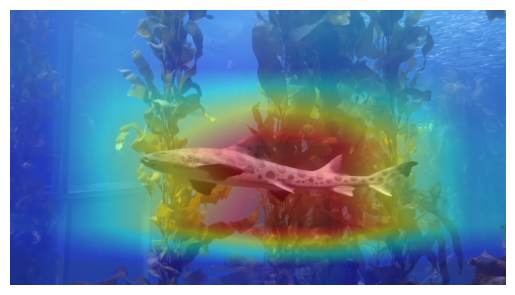

Predicted class: grey whale (index: 147, probability: 0.02%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


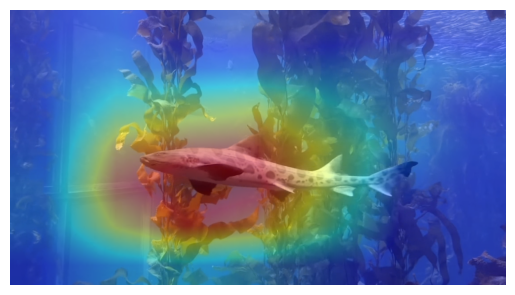

Predicted class: plastic bag (index: 728, probability: 0.00%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


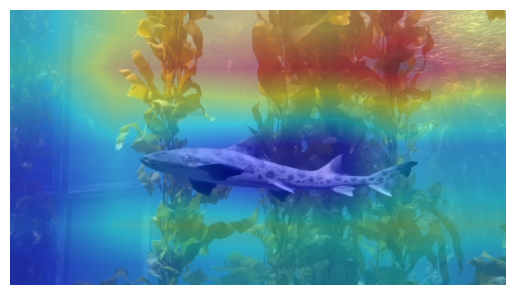

Predicted class: coral reef (index: 973, probability: 0.03%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
img (1194, 2152, 3)
heatmap (1194, 2152)


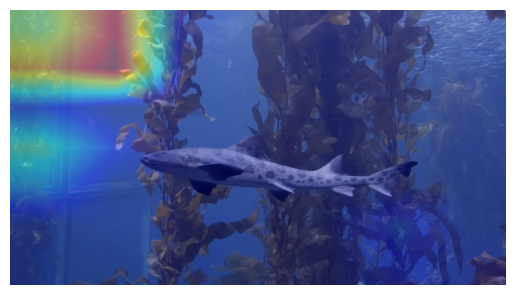

Predicted class: bubble (index: 971, probability: 0.00%)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [47]:
# load model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()
layer_name, target_layer = find_last_conv_layer(model)

# create GradCAM object
gradcam = GradCAM(model, target_layer)


def show_gradcam(
        image_path, 
        interesting_classes=interesting_classes,
        model=model,
        gradcam=gradcam,
    ):
    # load inputs
    input_image = Image.open(image_path).convert("RGB")  # ensure 3 channels
    input_batch = preprocess(input_image).unsqueeze(0)

    # get highest probability class
    probs = torch.softmax(model(input_batch), dim=1)
    predicted_class_idx = torch.argmax(probs, dim=1).item()
    predicted_class_name = class_labels[predicted_class_idx]
    heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(input_batch, predicted_class_idx)
    visualize_heatmap(image_path, heatmap)
    print(f"Predicted class: {predicted_class_name} (index: {predicted_class_idx}, probability: {predicted_prob:.2%})")
    print("~"*50)

    # iterate over interesting classes
    for class_name, class_idx in interesting_classes.items():
        heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(input_batch, class_idx)
        predicted_class_name = class_labels[predicted_class_idx]
        visualize_heatmap(image_path, heatmap)
        print(f"Predicted class: {class_name} (index: {class_idx}, probability: {predicted_prob:.2%})")
        print("~"*50)

show_gradcam("../data/image/tiger-shark.png")